# 인물사진을 만들어 보자

## 실행환경
LMS에서 동작하는 것을 가정합니다.

In [67]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 데이터 준비하기

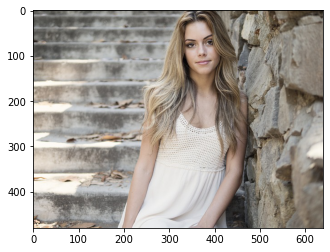

In [68]:
# LMS 클라우드 상의 이미지를 불러오고 이를 cv2로 로드
# img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_path = os.getenv('HOME')+'/aiffel/imgs/woman-g81b0e7b50_640.png'  

img_orig = cv2.imread(img_path) 

# 그리고 이것을 출력
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [69]:
# 모델 준비 과정

# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fb69c906610>)

In [70]:
# 이미지 세그멘테이션 모델 호출
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [71]:
# 모델 세그멘테이션
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

In [72]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

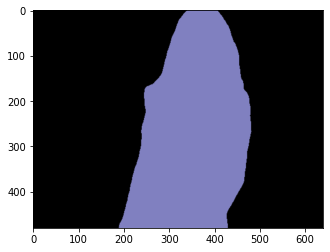

In [73]:
# 세그멘테이션 결과 출력
plt.imshow(output)
plt.show()

In [74]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [75]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [76]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [77]:
# 사람 세그멘테이션 컬러 추출
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

In [78]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(480, 640)


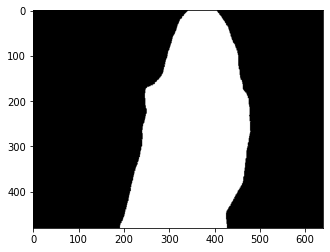

In [79]:
# 마스크 필터
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

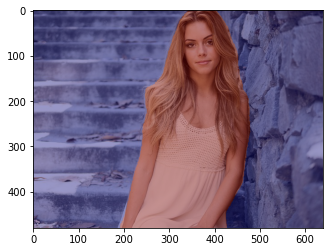

In [80]:
# 세그멘테이션 결과 보기
# 이미지 복사
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 치환
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변경
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 합성
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

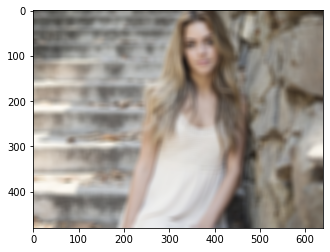

In [81]:
# 이미지 블러
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

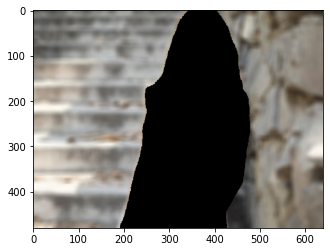

In [82]:
# 배경 필터 적용

# 이미지 체널 변경
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 비트 와이즈 연산인데 논리 부정 노드 생각하면 될듯
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 이미지 합성
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

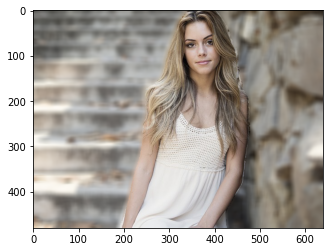

In [83]:
# 배경 블러 적용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

이걸로 인물 모드 사진에 아웃포커싱 효과를 부여하는데 성공함

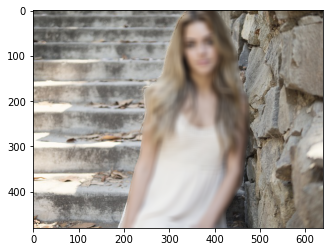

In [84]:
# 배경 블러 반대로
img_concat = np.where(img_mask_color==0, img_orig, img_orig_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 동물 사진 세그멘테이션

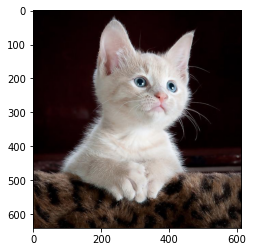

In [85]:
# 이미지 가져오고 테스트
img_path = os.getenv('HOME')+'/aiffel/imgs/cat-g9de94964a_640.jpg'  

img_orig = cv2.imread(img_path) 
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [86]:
# 세그멘테이션 진행
segvalues, output = model.segmentAsPascalvoc(img_path)

In [87]:
# 클래스 추출
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [88]:
colormap[8]

array([64,  0,  0])

In [89]:
# BGR 순으로 변경
seg_color = (0,0,64)

(640, 613)


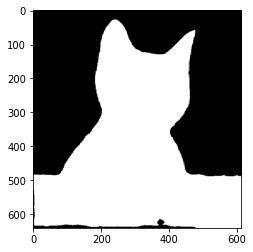

In [90]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

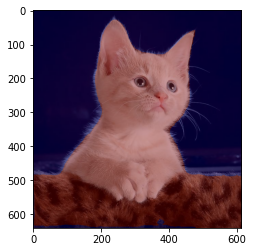

In [91]:

img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

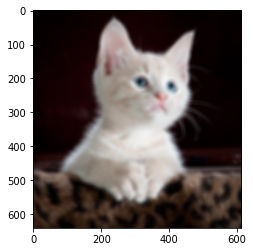

In [92]:
# 이미지 블러
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

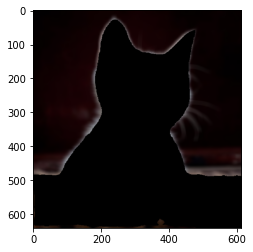

In [93]:
# 배경 필터 적용

# 이미지 체널 변경
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 비트 와이즈 연산인데 논리 부정 노드 생각하면 될듯
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 이미지 합성
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

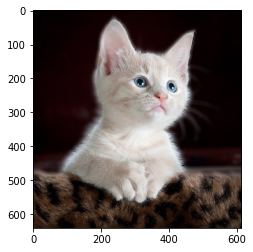

In [94]:
# 배경 블러 적용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

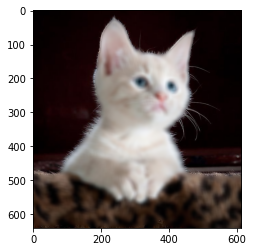

In [95]:
# 배경 블러 반대로
img_concat = np.where(img_mask_color==0, img_orig, img_orig_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

이것으로 고양이 사진에 아웃포커싱 효과를 부여하는데 성공함

## 배경전환 크로마키사진

In [96]:
img_orig.shape

(640, 613, 3)

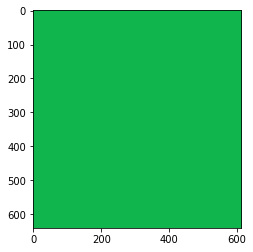

In [101]:
# 이미지 가져오고 테스트
img_path = os.getenv('HOME')+'/aiffel/imgs/cromach.png'  

cromach = cv2.imread(img_path) 
cromach = cv2.resize(cromach, (613, 640))
plt.imshow(cv2.cvtColor(cromach, cv2.COLOR_BGR2RGB))
plt.show()

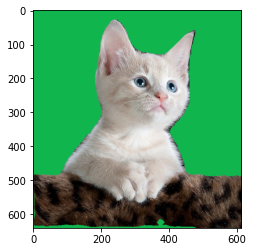

In [102]:
img_concat = np.where(img_mask_color==255, img_orig, cromach)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

크로마키 적용은 간단하게 배경이미지를 blur된 오리지널 이미지가 아니라 초록색 배경화면으로 대체하여 구현했다.

## semantic segmentation mask의 문제점

### 내 환경에서 발생한 문제점들

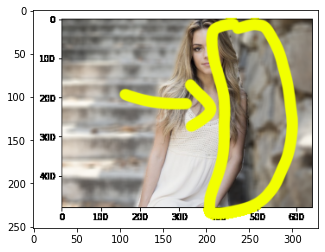

In [103]:
img_path = os.getenv('HOME')+'/aiffel/imgs/res1.png'  

cromach = cv2.imread(img_path) 
plt.imshow(cv2.cvtColor(cromach, cv2.COLOR_BGR2RGB))
plt.show()

문제는 아니지만 사소하게 경계를 잘 잡지 못했다.

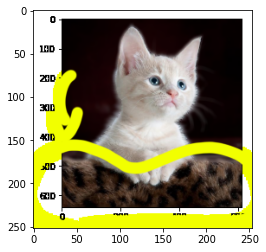

In [104]:
img_path = os.getenv('HOME')+'/aiffel/imgs/res2.png'  

cromach = cv2.imread(img_path) 
plt.imshow(cv2.cvtColor(cromach, cv2.COLOR_BGR2RGB))
plt.show()

아래의 쇼파도 털이라고 인식해서 함께 세그멘테이션 됬다.
저 정보만으로는 저것이 쇼파인지 다른 고양이인 털인지 알기 어렵지만, 나름 아쉬운 요소로 보인다.

### 인물 사진의 문제점을 개선할 수 있는 솔루션

저는 이 해답을 찾기위해 인공지능 기술을 활용하여 조사해봤습니다.

#### ChatGPT (GPT 3.5)
Semantic segmentation mask의 오류를 보완하기 위한 좋은 솔루션은 다음과 같습니다:

1. 더 정확한 모델 사용: 더 정확한 시맨틱 세그멘테이션 모델을 사용하는 것이 가장 효과적입니다. 최신 모델이나 사전 훈련된 모델을 사용하여 보다 정확한 예측을 얻을 수 있습니다. 모델을 업데이트하거나 다른 모델을 시도해보는 것이 오류를 줄이는 데 도움이 될 수 있습니다.

2. 데이터 양 늘리기: 더 많은 다양한 훈련 데이터를 사용하여 모델을 학습시킬 수 있습니다. 다양한 라벨이 있는 다양한 이미지를 사용하면 모델이 더 다양한 상황에서 정확한 예측을 할 수 있게 됩니다. 데이터 확장 기법(예: 데이터 증강, 합성 데이터 생성)을 사용하여 데이터 양을 증가시킬 수도 있습니다.

3. 후처리 기법 적용: 예측된 마스크에 대해 후처리 기법을 적용하여 오류를 보정할 수 있습니다. 예를 들어, 마스크의 작은 구멍을 메우거나 작은 분리된 영역을 제거하는 등의 작업을 수행할 수 있습니다. 이를 통해 예측된 마스크를 더 일관성 있고 정확하게 만들 수 있습니다.

4. 앙상블 기법 사용: 여러 모델의 예측을 결합하여 보다 정확한 예측을 얻을 수 있습니다. 여러 다른 모델을 훈련시키고 예측 결과를 평균화하거나 투표를 통해 최종 마스크를 생성하는 것이 가능합니다. 이를 통해 다양한 모델의 강점을 결합하여 보다 신뢰할 수 있는 결과를 얻을 수 있습니다.

5. 모델 해석 및 디버깅: 모델의 동작을 해석하고 디버깅하여 오류의 원인을 파악할 수 있습니다. 모델이 어떤 클래스에서 오류를 자주 발생시키는지 분석하고 해당 클래스에 대한 추가 데이터나 모델 수정을 고려할 수 있습니다. 또한, 모델이 주로 어떤 패턴에서 오류를 발생시키는지 분석하여 해당 패턴을 인지하고 보정하는 방법을 모색할 수 있습니다.

이러한 솔루션은 시맨틱 세그멘테이션 마스크의 오류를 최소화하고 정확성을 향상시키는 데 도움이 됩니다. 선택하는 솔루션은 데이터, 모델 및 문제의 특성에 따라 다를 수 있으며, 종합적인 접근 방식이 가장 효과적일 수 있습니다.

#### ChatGPT (GPT 4.0)
Semantic Segmentation Mask의 오류를 보완하는 여러 가지 방법이 있습니다. 주요한 몇 가지를 제시하겠습니다:

1. 데이터 향상 (Data Augmentation): 정확도를 향상시키고 모델을 더 견고하게 만들기 위해 데이터 향상을 사용할 수 있습니다. 이는 회전, 확대/축소, 이동 등의 방법으로 원본 이미지를 변형하여 모델이 다양한 상황에 대해 학습하게 하여 오류를 줄입니다.

2. 앙상블 학습 (Ensemble Learning): 여러 모델을 학습시키고, 그 결과를 합침으로써 더 안정적인 결과를 얻을 수 있습니다. 단일 모델의 한계를 넘어서므로 이 방법이 오류를 줄이는 데 효과적일 수 있습니다.

3. 다양한 Loss Function 사용: 기존에 사용하던 Loss Function 외에도 다양한 Loss Function을 사용해 보는 것이 도움이 될 수 있습니다. 예를 들어, Dice Loss나 Tversky Loss 같은 것들은 분할 문제에 대해 더 좋은 결과를 내는 경우가 많습니다.

4. 인스턴스 정규화 (Instance Normalization): 인스턴스 정규화는 학습 과정에서 각 이미지의 픽셀 값 분포를 정규화하여 학습의 안정성을 높이는 방법입니다. 이는 각 이미지가 독립적으로 정규화되므로, 배치 크기에 따른 변화에 덜 민감하며, 학습이 빠르고 안정적입니다.

5. 사전 학습된 모델 (Pre-trained Models): 사전에 학습된 모델을 사용하여 전이 학습(Transfer Learning)을 수행하는 것도 오류를 줄이는 데 도움이 됩니다. 이는 더 큰 데이터 세트에서 훈련된 모델의 학습된 특징을 활용할 수 있기 때문에, 보다 빠르고 효과적으로 모델을 훈련시킬 수 있습니다.

6. 더 많은 학습 데이터 확보: 모델이 충분한 양의 데이터를 가지고 학습하면, 오류를 줄이는 데 도움이 됩니다. 데이터가 많을수록, 모델은 더 많은 패턴을 학습하고, 따라서 일반화 능력이 향상됩니다.

각각의 솔루션이 모델의 성능을 향상시키는 데 도움이 될 수 있지만, 구체적인 솔루션은 데이터의 특성, 프로젝트의 요구 사항, 사용 가능한 리소스 등 다양한 요인에 따라 달라질 수 있습니다. 따라서 여러 방법을 시도하고, 어떤 방법이 가장 효과적인지 실험적으로 결정하는 것이 중요합니다.

#### Bard
의미 분할 마스크의 오류를 보완하는 좋은 솔루션은 유사한 이미지에서 데이터 증강을 사용하는 것입니다. 데이터 증강은 기존 이미지를 변경하여 더 많은 데이터 세트를 만드는 프로세스입니다. 이렇게 하면 모델이 더 다양한 이미지에 대해 학습할 수 있으므로 오류에 대해 더 강력해집니다.

유사한 이미지에서 데이터 증강을 사용하면 두 이미지 간의 유사성을 유지할 수 있으므로 모델이 오류를 예측할 가능성이 줄어듭니다. 예를 들어, 모델이 사람의 이미지에 오류가 있는 경우 사람과 유사한 이미지의 데이터 증강을 사용하여 오류를 수정할 수 있습니다.

유사한 이미지에서 데이터 증강을 사용하는 방법에는 여러 가지가 있습니다. 한 가지 방법은 이미지를 회전, 뒤집기 또는 크기 조정하는 것입니다. 다른 한 가지 방법은 이미지에 노이즈를 추가하거나 블러 처리하는 것입니다. 가장 적합한 방법은 특정 문제에 따라 다릅니다.

유사한 이미지에서 데이터 증강은 의미 분할 마스크의 오류를 보완하는 효과적인 방법이 될 수 있습니다. 모델이 더 다양한 이미지에 대해 학습할 수 있도록 하여 오류에 대해 더 강력해질 수 있습니다.

#### 결론

**유사 데이터 증강**은 모든 Ai 솔루션이 공통으로 대답한 답변이었습니다.
좀 더 정확한 판정을 위해서는 패턴 인식 알고리즘 측면에서의 개선도 중요하지만, 데이터를 더 많이 확보해서 최대한 넓은 범위의 여러 이미지를 처리할 수 있도록 하는 것이 좋을 것으로 보입니다.